### Walmart Sales Analysis

#### Importing Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


#### Loading Data

In [2]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
# data = pd.read_csv("features.csv", parse_dates=["Date"], index_col=["Date"])
# data

In [3]:
features.head(3)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


In [4]:
stores.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


In [5]:
test.head(3)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False


In [6]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


#### Merge

In [7]:
data = train.merge(features, how="left").merge(stores, how="left")
data.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315


#### Cleaning Data

In [8]:
data.shape

(421570, 16)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


Checking for missing values

In [10]:
missing_vals = data.isna().sum()/len(data)
missing_vals

Store           0.000000
Dept            0.000000
Date            0.000000
Weekly_Sales    0.000000
IsHoliday       0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
Type            0.000000
Size            0.000000
dtype: float64

Dropping Columns with more than 15%

In [11]:
# Removing null values from columns greater than 15%
columns_to_drop_from = missing_vals[missing_vals >= 0.15].index
clean_data = data.drop(columns=columns_to_drop_from)

Checking for duplicate values or date

In [12]:
clean_data.index.duplicated().sum()

0

In [13]:
clean_data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,227.232807,14.313000,219622.000000


In [14]:
clean_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


In [15]:
# correcting the date column dtype
# clean_data["Date"] = clean_data["Date"].astype("datetime64[ns]")
clean_data["Date"] = pd.to_datetime(clean_data["Date"])

In [16]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   CPI           421570 non-null  float64       
 8   Unemployment  421570 non-null  float64       
 9   Type          421570 non-null  object        
 10  Size          421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 32.6+ MB


Setting the Index to date

In [17]:
clean_data = clean_data.set_index("Date")

In [18]:
clean_data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
Date,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
2010-02-12,1,1,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2010-02-19,1,1,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
2010-02-26,1,1,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
2010-03-05,1,1,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


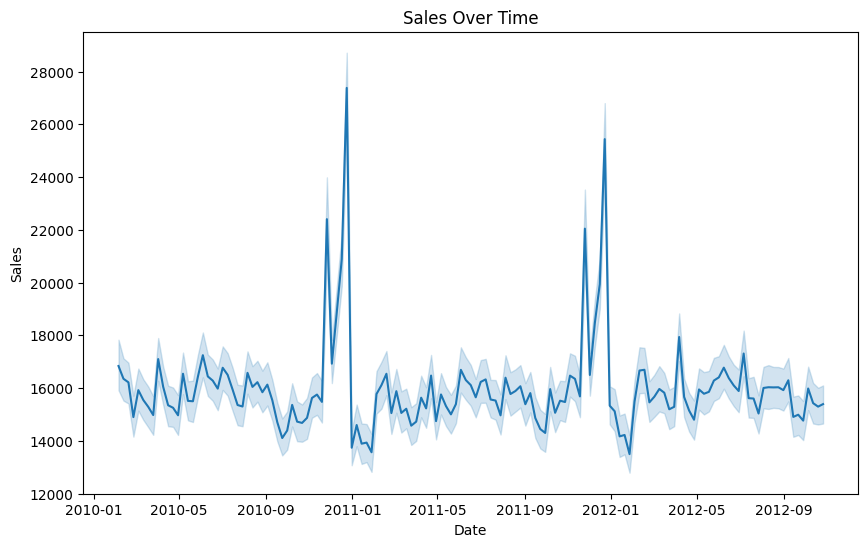

In [19]:
# Visualize the data
plt.figure(figsize=(10, 6))
sns.lineplot(x=clean_data.index, y=clean_data['Weekly_Sales'])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Setting the frequency of the data

In [20]:
clean_data["Weekly_Sales"]

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
                ...   
2012-09-28      508.37
2012-10-05      628.10
2012-10-12     1061.02
2012-10-19      760.01
2012-10-26     1076.80
Name: Weekly_Sales, Length: 421570, dtype: float64

In [21]:
clean_data.index.duplicated().sum()

421427

In [22]:
# Remove duplicate dates
clean_data = clean_data[~clean_data.index.duplicated(keep='first')]

In [23]:
clean_data.index.duplicated().sum()

0

In [24]:
clean_data

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
Date,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
2010-02-12,1,1,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2010-02-19,1,1,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
2010-02-26,1,1,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
2010-03-05,1,1,21827.90,False,46.50,2.625,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1,1,18947.81,False,76.08,3.666,222.981658,6.908,A,151315
2012-10-05,1,1,21904.47,False,68.55,3.617,223.181477,6.573,A,151315
2012-10-12,1,1,22764.01,False,62.99,3.601,223.381296,6.573,A,151315


Decomposing the time series (Trend, Seasonality, Residuals)

In [25]:
# Decompose the time series
decomposition = seasonal_decompose(clean_data["Weekly_Sales"], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

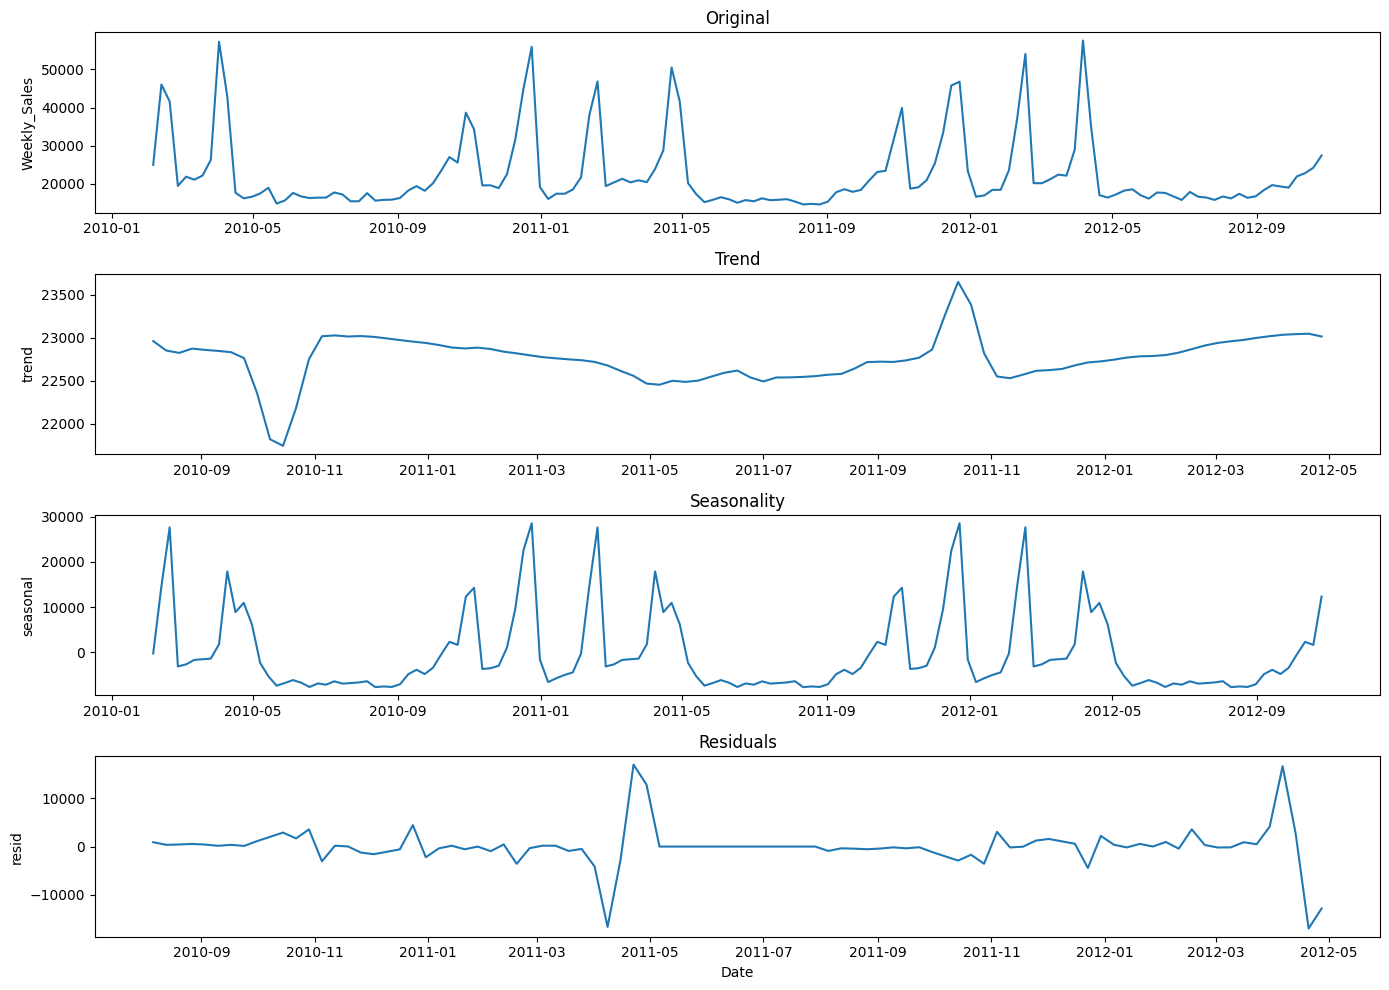

In [26]:
plt.figure(figsize=(14, 10))

plt.subplot(411)
sns.lineplot(x=clean_data.index, y=clean_data['Weekly_Sales'])
plt.title('Original')
plt.xlabel('')

plt.subplot(412)
sns.lineplot(x=trend.index, y=trend)
plt.title('Trend')
plt.xlabel('')

plt.subplot(413)
sns.lineplot(x=seasonal.index, y=seasonal)
plt.title('Seasonality')
plt.xlabel('')

plt.subplot(414)
sns.lineplot(x=residual.index, y=residual)
plt.title('Residuals')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

Stationary Check (if p-value is lower 0.05 the data is stationary)

In [27]:
# Check for stationarity
result = adfuller(clean_data['Weekly_Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.5221638686500403
p-value: 0.11017432282586914


data is non-stationary

Differencing to make the series stationary

In [28]:
# Differencing to make the series stationary if necessary
clean_data['Sales_diff'] = clean_data['Weekly_Sales'].diff()
clean_data = clean_data.dropna()

In [29]:
clean_data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Sales_diff
Date,,,,,,,,,,,
2010-02-12,1,1,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,21114.99
2010-02-19,1,1,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,-4443.94
2010-02-26,1,1,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,-22192.01
2010-03-05,1,1,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,2424.36
2010-03-12,1,1,21043.39,False,57.79,2.667,211.380643,8.106,A,151315,-784.51


Building An Arima Model

In [30]:
# Split the data into training and test sets
train_size = int(len(clean_data) * 0.8)  # Using 80% of the data for training
train, test = clean_data.iloc[:train_size], clean_data.iloc[train_size:]


In [31]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [32]:
pm.auto_arima(train['Sales_diff'])

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [35]:
# Fit an ARIMA model
model = ARIMA(train['Sales_diff'], order=(2,0,1))
fit = model.fit()
fit.summary()

d:\my files\data sci\.env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
d:\my files\data sci\.env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
d:\my files\data sci\.env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Sales_diff   No. Observations:                  113
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1185.842
Date:                Sun, 30 Jun 2024   AIC                           2381.684
Time:                        00:20:23   BIC                           2395.320
Sample:                    02-12-2010   HQIC                          2387.217
                         - 04-06-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        289.0928    296.385      0.975      0.329    -291.810     869.996
ar.L1          0.6625      0.148      4.481      0.000       0.373       0.952
ar.L2         -0.3722      0.122     -3.055      0.002      -0.611      -0.133
ma.L1         -0.8345      0.132     -6.309      0.000      -1.094      -0.575
sigma2      8.418e+07      0.003   3.31e+10      0.000    8.42e+07    8.42e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                30.47
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.66
Prob(H) (two-sided):                  0.44   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.86e+26. Standard errors may be unstable.
"""

In [43]:
# Forecast on the test set
forecast_steps = len(test)
forecast = fit.forecast(steps=forecast_steps)

# Create a DataFrame for the forecasted data
forecast_index = test.index
forecast_df = pd.DataFrame({'Forecast': forecast, 'Actual':test['Sales_diff']}, index=forecast_index)

# Calculate accuracy metrics
mae = mean_absolute_error(test['Sales_diff'], forecast)
mse = mean_squared_error(test['Sales_diff'], forecast)
rmse = np.sqrt(mse)


In [38]:
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 1996.47
Mean Squared Error (MSE): 13831037.30
Root Mean Squared Error (RMSE): 3719.01


In [39]:
# # Forecast
# forecast = fit.forecast(steps=12)
# print(f"Forecast {forecast}")
# # print(f"Standard Error {stderr}")
# # print(f"Coefficient {conf_int}")
# print(forecast)
# forecast.to_frame()

In [44]:
forecast_df

,Forecast,Actual
Date,,
2012-04-13,-5687.881699,-22907.91
2012-04-20,-14222.703757,-17708.02
2012-04-27,-7099.686798,-628.59
2012-05-04,795.795573,799.84
2012-05-11,3374.960133,1016.76
2012-05-18,2144.755355,353.59
2012-05-25,369.796288,-1554.24
2012-06-01,-348.145376,-898.06
2012-06-08,-163.090859,1600.51


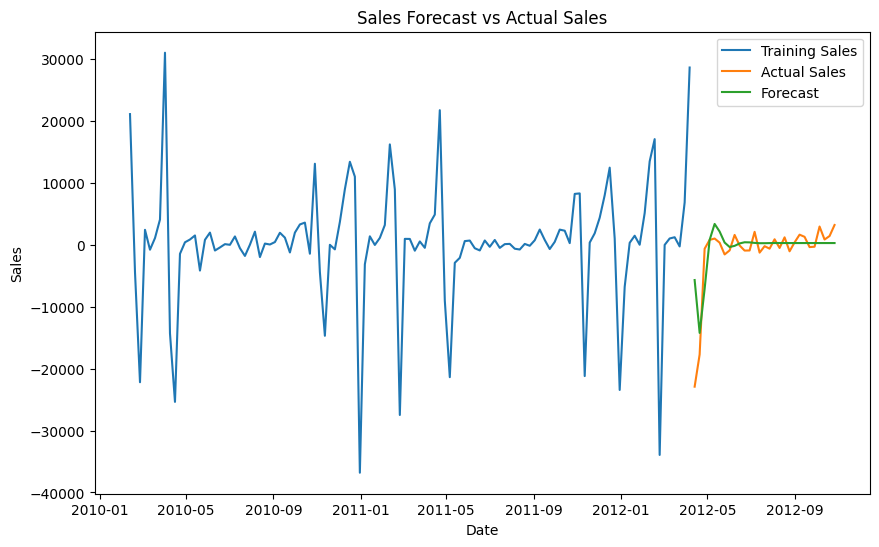

In [45]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=train.index, y=train['Sales_diff'], label='Training Sales')
sns.lineplot(x=test.index, y=test['Sales_diff'], label='Actual Sales')
sns.lineplot(x=forecast_df.index, y=forecast_df['Forecast'], label='Forecast')
plt.title('Sales Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
